In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg
import os
import pandas as pd
from sqlalchemy import create_engine
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import nltk
import numpy as np
import re

In [2]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=8) 
plt.rc('axes', titlesize=8) 
plt.rc('axes', labelsize=8) 
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.rc('legend', fontsize=8)
%config InlineBackend.figure_format = 'retina'
pd.options.display.float_format = '{:.0f}'.format

In [3]:
df = pd.read_csv('datasets/oal_dt_dataset.csv', 
                 names=['doi', 'pm_grouptype', 'type', 'abstract', 'title', 'page', 'author_count',
                          'has_license', 'is_referenced_by_count',
                          'references_count', 'has_funder'],
                 dtype={'doi': str,
                        'pm_grouptype': str,
                        'type': str,
                        'abstract': str,
                        'title': str,
                        'page': str,
                        'author_count': int,
                        'has_license': int,
                        'is_referenced_by_count': int,
                        'references_count': int,
                        'has_funder': int
                 }, sep=',', quotechar='"', header=0)

In [28]:
df.head()

,doi,pm_grouptype,type,abstract,title,page,author_count,has_license,is_referenced_by_count,references_count,has_funder
0,10.1001/2012.jama.10425,Journal_Article,research_discourse,NaN,A Path to Wholeness,985,4,0,1,0,0
1,10.1001/2012.jama.10452,Journal_Article,research_discourse,NaN,Worries,873,1,0,1,0,0
2,10.1001/2012.jama.10500,News,editorial_discourse,NaN,Critics of US House Proposal to Ax AHRQ Say Id...,849,1,0,0,0,0
3,10.1001/2012.jama.10931,Editorial,editorial_discourse,NaN,Atherogenic Vascular Stiffness and Hypertension,919,1,0,11,0,0
4,10.1001/2012.jama.10939,News,editorial_discourse,NaN,Lessons From Massachusetts: Cost Remains a Hur...,961,1,0,1,0,0


In [29]:
df.describe()

,author_count,has_license,is_referenced_by_count,references_count,has_funder
count,9600576,9600576,9600576,9600576,9600576
mean,6,1,24,41,0
std,14,0,86,38,0
min,0,0,0,0,0
25%,3,0,3,20,0
50%,5,1,10,36,0
75%,8,1,24,53,1
max,7194,1,50758,4084,1


In [30]:
pd.reset_option('float_format')

In [31]:
df.value_counts(subset=['type'], normalize=False, dropna=False)

type               
research_discourse     8847957
editorial_discourse     737634
not assigned             14985
Name: count, dtype: int64

In [32]:
df.value_counts(subset=['type'], normalize=True, dropna=False)

type               
research_discourse     0.921607
editorial_discourse    0.076832
not assigned           0.001561
Name: proportion, dtype: float64

In [33]:
df.groupby(['type'])['author_count'].median()

type
editorial_discourse    3.0
not assigned           1.0
research_discourse     5.0
Name: author_count, dtype: float64

In [34]:
df.groupby(['type'])['author_count'].mean()

type
editorial_discourse    3.832516
not assigned           2.706507
research_discourse     6.467811
Name: author_count, dtype: float64

In [35]:
df.groupby(['type'])['author_count'].std()

type
editorial_discourse    10.625834
not assigned            4.867568
research_discourse     14.306363
Name: author_count, dtype: float64

In [36]:
df.groupby(['type'])['has_license'].mean()

type
editorial_discourse    0.728935
not assigned           0.643977
research_discourse     0.745046
Name: has_license, dtype: float64

In [37]:
df.groupby(['type'])['has_funder'].mean()

type
editorial_discourse    0.075181
not assigned           0.033433
research_discourse     0.371085
Name: has_funder, dtype: float64

In [38]:
df.groupby(['type'])['is_referenced_by_count'].median()

type
editorial_discourse     1.0
not assigned            1.0
research_discourse     11.0
Name: is_referenced_by_count, dtype: float64

In [39]:
df.groupby(['type'])['is_referenced_by_count'].mean()

type
editorial_discourse     5.225850
not assigned            6.617551
research_discourse     25.133649
Name: is_referenced_by_count, dtype: float64

In [40]:
df.groupby(['type'])['is_referenced_by_count'].std()

type
editorial_discourse    32.419062
not assigned           37.682823
research_discourse     89.163083
Name: is_referenced_by_count, dtype: float64

In [41]:
df.groupby(['type'])['references_count'].median()

type
editorial_discourse     5.0
not assigned            1.0
research_discourse     38.0
Name: references_count, dtype: float64

In [42]:
df.groupby(['type'])['references_count'].mean()

type
editorial_discourse     7.690521
not assigned           11.891091
research_discourse     44.158984
Name: references_count, dtype: float64

In [43]:
df.groupby(['type'])['references_count'].std()

type
editorial_discourse    11.982958
not assigned           30.335630
research_discourse     38.466158
Name: references_count, dtype: float64

In [44]:
def page_counter(page_str):
    page_int = 1
    if '-' in str(page_str):
        try:
            #page_str = re.sub('[^\d-]', '', page_str)
            page_int = int(abs(eval(page_str)))
            if page_int > 5000:
                page_int = 5000
        except:
            pass
        
    return page_int

In [45]:
df['page_count'] = df.page.apply(page_counter)
df['page_count'] = df['page_count'].astype(int)

In [46]:
df.groupby(['type'])['page_count'].median()

type
editorial_discourse    1.0
not assigned           1.0
research_discourse     5.0
Name: page_count, dtype: float64

In [47]:
df.groupby(['type'])['page_count'].mean()

type
editorial_discourse    13.999740
not assigned            7.417017
research_discourse     37.256127
Name: page_count, dtype: float64

In [48]:
df.groupby(['type'])['page_count'].std()

type
editorial_discourse    247.505620
not assigned           141.760510
research_discourse     392.263671
Name: page_count, dtype: float64

In [4]:
df['title_word_length']  = df['title'].str.split().str.len()
df['abstract_word_length']  = df['abstract'].str.split().str.len()

In [5]:
df.groupby(['type'])['title_word_length'].median()

type
editorial_discourse   11
not assigned           8
research_discourse    14
Name: title_word_length, dtype: float64

In [6]:
df.groupby(['type'])['title_word_length'].mean()

type
editorial_discourse   12
not assigned           9
research_discourse    14
Name: title_word_length, dtype: float64

In [7]:
df.groupby(['type'])['title_word_length'].std()

type
editorial_discourse   6
not assigned          6
research_discourse    5
Name: title_word_length, dtype: float64

In [8]:
df.groupby(['type'])['abstract_word_length'].median()

type
editorial_discourse    44
not assigned          129
research_discourse    207
Name: abstract_word_length, dtype: float64

In [9]:
df.groupby(['type'])['abstract_word_length'].mean()

type
editorial_discourse    95
not assigned          141
research_discourse    207
Name: abstract_word_length, dtype: float64

In [10]:
df.groupby(['type'])['abstract_word_length'].std()

type
editorial_discourse   106
not assigned           85
research_discourse     81
Name: abstract_word_length, dtype: float64

In [11]:
df['title_string_length']  = df['title'].str.len()
df['abstract_string_length']  = df['abstract'].str.len()

In [12]:
df.groupby(['type'])['title_string_length'].median()

type
editorial_discourse    81
not assigned           58
research_discourse    105
Name: title_string_length, dtype: float64

In [13]:
df.groupby(['type'])['title_string_length'].mean()

type
editorial_discourse    87
not assigned           65
research_discourse    108
Name: title_string_length, dtype: float64

In [14]:
df.groupby(['type'])['title_string_length'].std()

type
editorial_discourse   47
not assigned          43
research_discourse    39
Name: title_string_length, dtype: float64

In [15]:
df.groupby(['type'])['abstract_string_length'].median()

type
editorial_discourse    378
not assigned           939
research_discourse    1605
Name: abstract_string_length, dtype: float64

In [16]:
df.groupby(['type'])['abstract_string_length'].mean()

type
editorial_discourse    770
not assigned          1048
research_discourse    1667
Name: abstract_string_length, dtype: float64

In [17]:
df.groupby(['type'])['abstract_string_length'].std()

type
editorial_discourse   943
not assigned          638
research_discourse    759
Name: abstract_string_length, dtype: float64

In [18]:
df['abstract'].isna().sum()

6319060

In [19]:
df[df.type == 'research_discourse']['abstract'].isna().sum() / len(df[df.type == 'research_discourse'])

0.6348776333338871

In [20]:
df[df.type == 'editorial_discourse']['abstract'].isna().sum() / len(df[df.type == 'editorial_discourse'])

0.9334764937624892

In [21]:
df[df.type == 'not assigned']['abstract'].isna().sum() / len(df[df.type == 'not assigned'])

0.8759426092759426

In [22]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
remove_html = re.compile('<.*?>')

def lemmatize_text(text):
    if pd.isna(text):
        text = ''
    text = str(text)
    text = text.lower()
    text = re.sub(remove_html, '', text)
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

df['title_lemmatized'] = df.title.apply(lemmatize_text)
#df['abstract_lemmatized'] = df.abstract.apply(lemmatize_text)

In [23]:
def generate_wordcloud(data):
    cloud = WordCloud(width=700,
                      height=500,
                      max_words=150,
                      colormap='tab20c',
                      collocations=False).generate_from_text(data)
    plt.figure(figsize=(10,8))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()

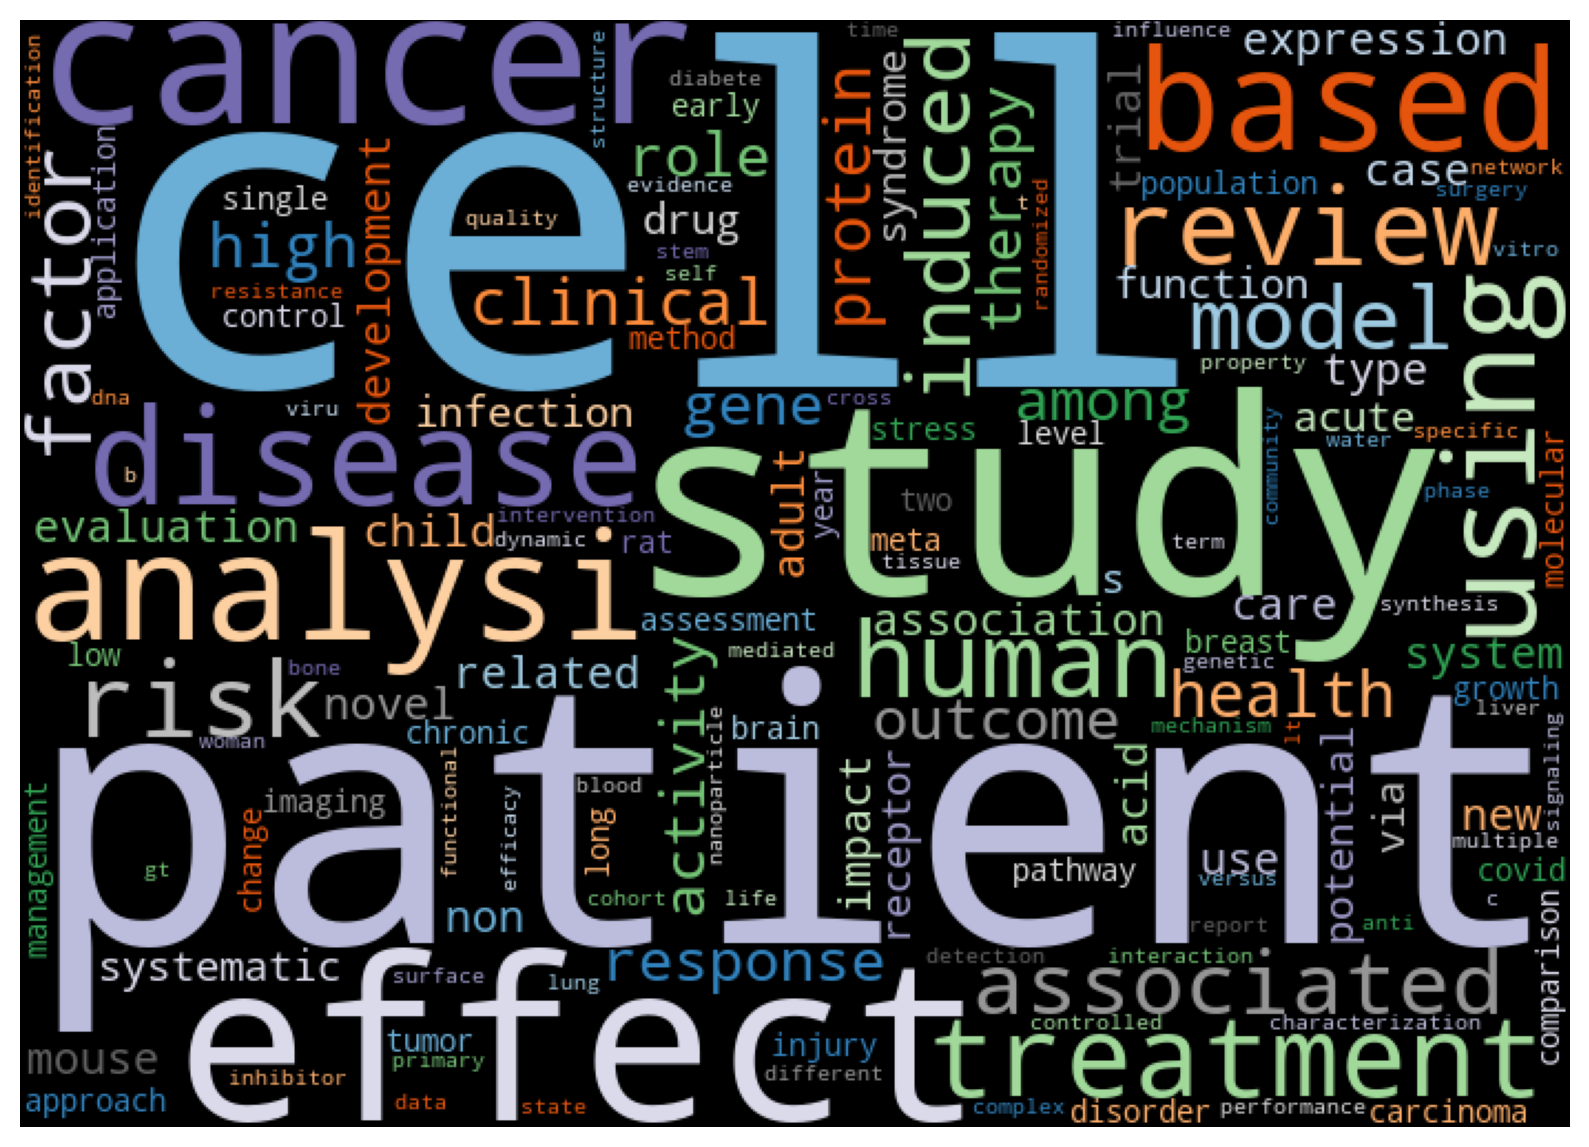

In [24]:
generate_wordcloud(' '.join(df[df.type == 'research_discourse']['title_lemmatized']))

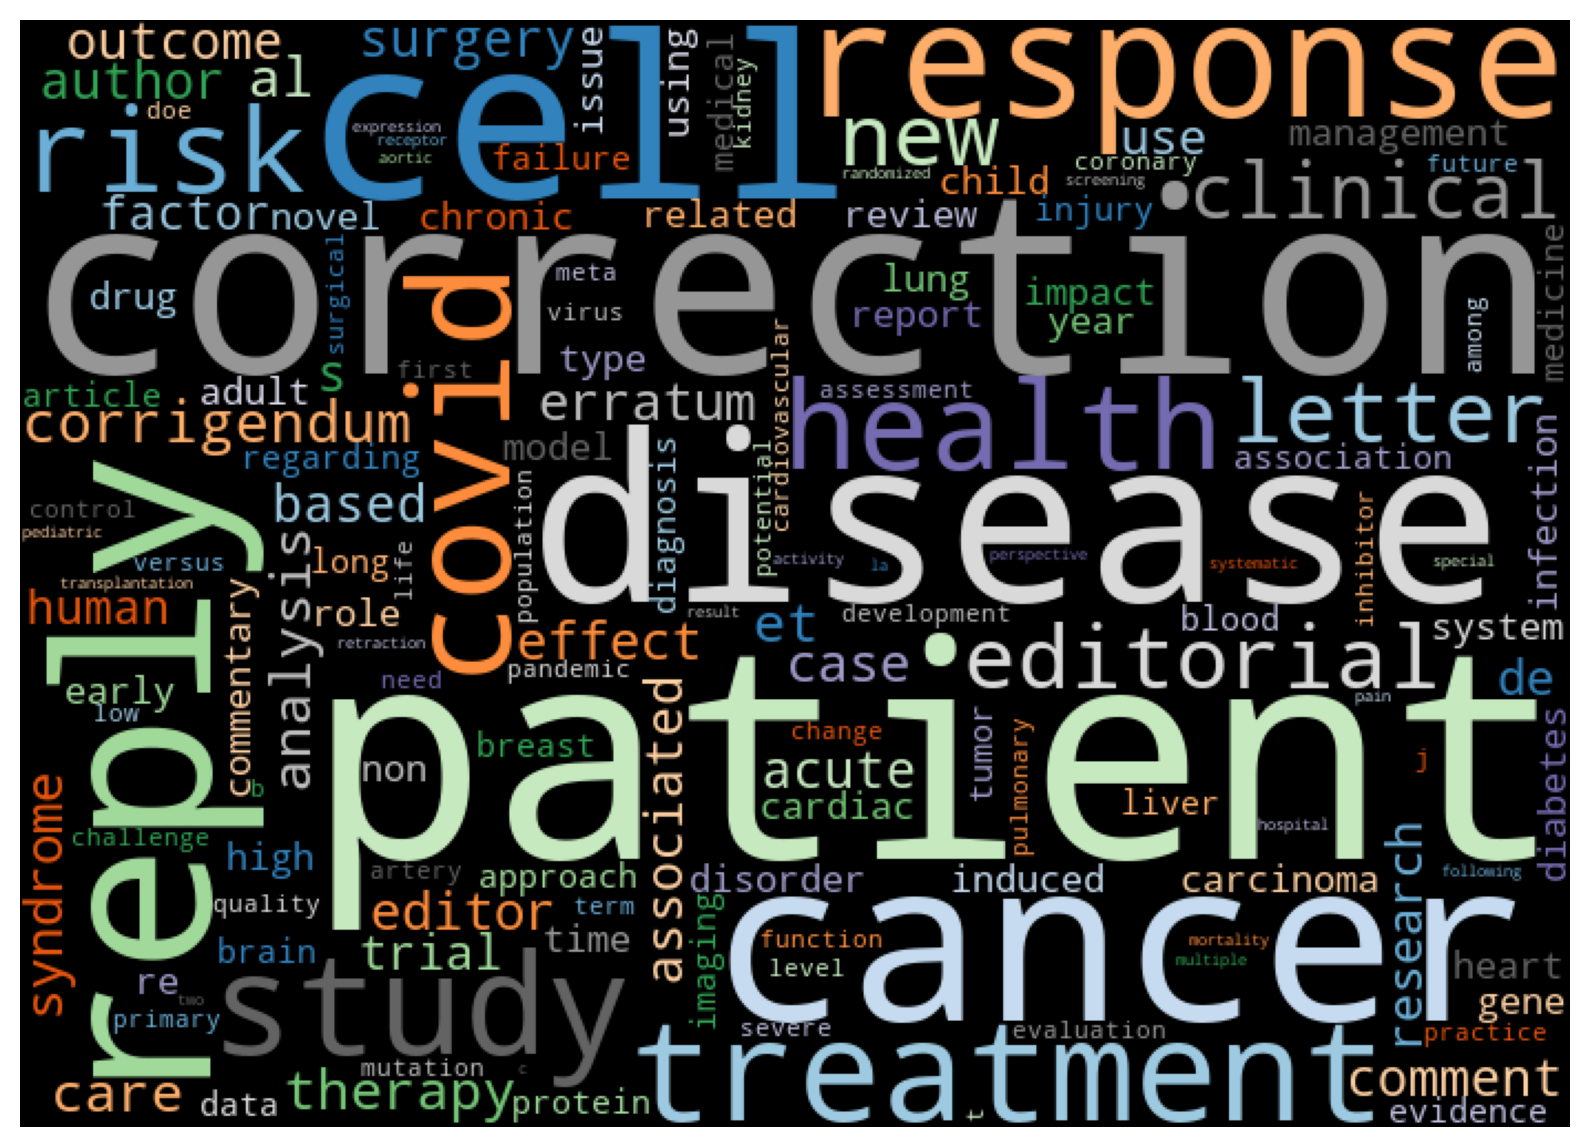

In [25]:
generate_wordcloud(' '.join(df[df.type == 'editorial_discourse']['title_lemmatized']))

In [112]:
#generate_wordcloud(' '.join(df[df.type == 'research_discourse']['abstract_lemmatized']))

In [113]:
#generate_wordcloud(' '.join(df[df.type == 'editorial_discourse']['abstract_lemmatized']))

In [6]:
host = os.environ['KB_HOST']
database = os.environ['KB_DATABASE']
user = os.environ['KB_USER']
pw = os.environ['KB_PASSWORD']
port = os.environ['KB_PORT']
engine = create_engine(f'postgresql://{user}:{pw}@{host}:{port}/{database}')

In [20]:
oal_type_oa = pd.read_sql("""
                          SELECT COUNT(DISTINCT(d.doi)) AS n, d.type AS type, pl.is_oa AS is_oa
                          FROM unignhaupka.oal_doc_dataset d
                          JOIN fiz_openalex_rep_20230819_openbib.works w
                              ON LOWER(TRIM('https://doi.org/' FROM w.doi)) = LOWER(d.doi)
                          JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations pl
                              ON w.id = pl.work_id
                          GROUP BY d.type, is_oa
                          ORDER BY n DESC
                          """, 
                          con=engine)

In [28]:
oal_type_oa['prop'] = oal_type_oa['n'] / oal_type_oa.groupby(['type'])['n'].transform('sum')
oal_type_oa

,n,type,is_oa,prop
0,4688614,research_discourse,False,0.529887
1,4159719,research_discourse,True,0.470113
2,378522,editorial_discourse,True,0.513189
3,359066,editorial_discourse,False,0.486811
4,8333,not assigned,False,0.555793
5,6660,not assigned,True,0.444207


In [32]:
oal_type_oa_status = pd.read_sql("""
                                 SELECT COUNT(DISTINCT(d.doi)) AS n, d.type AS type, woa.oa_status
                                 FROM unignhaupka.oal_doc_dataset d
                                 JOIN fiz_openalex_rep_20230819_openbib.works w
                                     ON LOWER(TRIM('https://doi.org/' FROM w.doi)) = LOWER(d.doi)
                                 JOIN fiz_openalex_rep_20230819_openbib.works_open_access woa
                                     ON w.id = woa.work_id
                                 GROUP BY d.type, woa.oa_status
                                 ORDER BY n DESC
                                 """, 
                                 con=engine)

In [42]:
oal_type_oa_status['prop'] = oal_type_oa_status['n'] / oal_type_oa_status.groupby(['type'])['n'].transform('sum')
oal_type_oa_status

,n,type,oa_status,prop
0,3729869,research_discourse,closed,0.421528
1,2519459,research_discourse,gold,0.284735
2,1082114,research_discourse,green,0.122294
3,899542,research_discourse,bronze,0.101661
4,617465,research_discourse,hybrid,0.069782
5,333787,editorial_discourse,closed,0.452554
6,219087,editorial_discourse,bronze,0.297042
7,110080,editorial_discourse,gold,0.149248
8,48280,editorial_discourse,green,0.065459
9,26328,editorial_discourse,hybrid,0.035696


In [45]:
oal_type_apc = pd.read_sql("""
                           SELECT COUNT(DISTINCT(d.doi)) AS n, d.type AS type, AVG((apc_list->>'value_usd')::numeric) AS apc
                           FROM unignhaupka.oal_doc_dataset d
                           JOIN fiz_openalex_rep_20230819_openbib.works w
                               ON LOWER(TRIM('https://doi.org/' FROM w.doi)) = LOWER(d.doi)
                           GROUP BY d.type
                           ORDER BY n DESC
                           """, 
                           con=engine)

In [46]:
oal_type_apc

,n,type,apc
0,8847736,research_discourse,3096.029307
1,737509,editorial_discourse,3882.455098
2,14985,not assigned,4056.178471


In [53]:
oal_type_license = pd.read_sql("""
                               SELECT COUNT(DISTINCT(d.doi)) AS n, d.type AS type, pl.license as license
                               FROM unignhaupka.oal_doc_dataset d
                               JOIN fiz_openalex_rep_20230819_openbib.works w
                                   ON LOWER(TRIM('https://doi.org/' FROM w.doi)) = LOWER(d.doi)
                               JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations pl
                                   ON w.id = pl.work_id
                               GROUP BY d.type, license
                               ORDER BY n DESC
                               """, 
                               con=engine)

In [59]:
oal_type_license['prop'] = (oal_type_license['n'] / oal_type_license.groupby(['type'])['n'].transform('sum')) * 100
oal_type_license.sort_values(by=['license'])

,n,type,license,prop
48,1,research_discourse,acs-specific,0.000011
29,482,editorial_discourse,acs-specific: authorchoice/editors choice usag...,0.065351
16,8159,research_discourse,acs-specific: authorchoice/editors choice usag...,0.092214
1,2095784,research_discourse,cc-by,23.686922
6,73645,editorial_discourse,cc-by,9.984977
25,903,not assigned,cc-by,6.026026
4,316148,research_discourse,cc-by-nc,3.573161
32,188,not assigned,cc-by-nc,1.254588
12,14270,editorial_discourse,cc-by-nc,1.934763
3,334125,research_discourse,cc-by-nc-nd,3.776340
